## 1. Load Libraries & Dataset

In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from time import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [13]:
# Load the feature-engineered dataset
df = pd.read_csv('flight_dataset_engineered.csv')

print("=" * 80)
print("DATASET LOADED")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"\n✅ Feature-engineered dataset loaded successfully")

DATASET LOADED
Shape: (300153, 57)

✅ Feature-engineered dataset loaded successfully


In [14]:
# Quick preview
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,departure_hour,arrival_hour,departure_period,arrival_period,duration_minutes,is_red_eye,stops_encoded,airline_Airasia,airline_Go First,airline_Indigo,airline_Spicejet,airline_Vistara,source_Chennai,source_Delhi,source_Hyderabad,source_Kolkata,source_Mumbai,destination_Chennai,destination_Delhi,destination_Hyderabad,destination_Kolkata,destination_Mumbai,class_Economy,dep_period_Evening,dep_period_Late Night,dep_period_Morning,dep_period_Night,arr_period_Evening,arr_period_Late Night,arr_period_Morning,arr_period_Night,price_per_hour,duration_category,booking_urgency,is_peak_hour,route_popularity,airline_avg_price,demand_score,is_direct,class_route_avg_price,duration_cat_medium_haul,duration_cat_short_haul,urgency_last_minute,urgency_one_month,urgency_one_week,urgency_two_weeks
0,Spicejet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,18,22,Evening,Night,130,0,0,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,True,2747.54,short_haul,last_minute,1,15289,6180.70,100.0,1,6059.83,False,True,True,False,False,False
1,Spicejet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,6,9,Morning,Morning,140,0,0,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,2551.29,short_haul,last_minute,1,15289,6180.70,100.0,1,6059.83,False,True,True,False,False,False
2,Airasia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,6,6,Morning,Morning,130,0,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,2748.92,short_haul,last_minute,1,15289,4096.95,100.0,1,6059.83,False,True,True,False,False,False
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,9,14,Morning,Afternoon,135,0,0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,2646.67,short_haul,last_minute,1,15289,30225.73,100.0,1,6059.83,False,True,True,False,False,False
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,9,9,Morning,Morning,140,0,0,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,2552.14,short_haul,last_minute,1,15289,30225.73,100.0,1,6059.83,False,True,True,False,False,False


## 2. Feature Preparation

In [15]:
# Identify features (same as Linear Regression)
print("=" * 80)
print("FEATURE PREPARATION")
print("=" * 80)

# Columns to exclude from features
exclude_cols = ['price', 'flight', 'airline', 'source_city', 'destination_city', 
                'departure_time', 'arrival_time', 'stops', 'class',
                'departure_period', 'arrival_period', 'duration_category', 'booking_urgency']

# Select features
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features: {len(feature_cols)}")
print(f"\nNote: Random Forest doesn't require feature scaling")

FEATURE PREPARATION
Total features: 44

Note: Random Forest doesn't require feature scaling


In [16]:
# Prepare X and y
X = df[feature_cols].copy()
y = df['price'].copy()

# Handle missing values
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print("✅ Missing values filled")

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (300153, 44)
y shape: (300153,)


## 3. Train-Test Split (80/20)

In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("=" * 80)
print("TRAIN-TEST SPLIT COMPLETED")
print("=" * 80)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Split ratio: {len(X_train)/len(X)*100:.1f}% train, {len(X_test)/len(X)*100:.1f}% test")

TRAIN-TEST SPLIT COMPLETED
Training set: (240122, 44)
Test set: (60031, 44)
Split ratio: 80.0% train, 20.0% test


## 4. Train Base Random Forest Model

In [18]:
# Train a base Random Forest model with default parameters
print("=" * 80)
print("TRAINING BASE RANDOM FOREST MODEL")
print("=" * 80)

start_time = time()

rf_base = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

rf_base.fit(X_train, y_train)

train_time = time() - start_time

print(f"\n✅ Base model trained in {train_time:.2f} seconds")

TRAINING BASE RANDOM FOREST MODEL


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.4s



✅ Base model trained in 29.44 seconds


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.3s finished


In [19]:
# Evaluate base model
y_train_pred_base = rf_base.predict(X_train)
y_test_pred_base = rf_base.predict(X_test)

def calculate_metrics(y_true, y_pred, dataset_name=""):
    """Calculate regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"   RMSE: ${rmse:,.2f}")
    print(f"   MAE: ${mae:,.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R²: {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

print("=" * 80)
print("BASE MODEL PERFORMANCE")
print("=" * 80)

base_train_metrics = calculate_metrics(y_train, y_train_pred_base, "TRAINING")
base_test_metrics = calculate_metrics(y_test, y_test_pred_base, "TEST")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


BASE MODEL PERFORMANCE

TRAINING Metrics:
   RMSE: $86.60
   MAE: $15.52
   MAPE: 0.08%
   R²: 1.0000

TEST Metrics:
   RMSE: $206.05
   MAE: $37.90
   MAPE: 0.21%
   R²: 0.9999


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


## 5. Hyperparameter Tuning using RandomizedSearchCV

In [20]:
# Define hyperparameter distributions for RandomizedSearchCV
print("=" * 80)
print("HYPERPARAMETER TUNING - RANDOMIZEDSEARCHCV")
print("=" * 80)

param_distributions = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None]
}

print("Parameter distributions:")
for param, values in param_distributions.items():
    print(f"   {param}: {values}")

n_iter = 5  # Number of random combinations to try
print(f"\nRandom combinations to test: {n_iter}")
print(f"With 2-fold CV: {n_iter * 2} model fits")

HYPERPARAMETER TUNING - RANDOMIZEDSEARCHCV
Parameter distributions:
   n_estimators: [100, 150, 200, 250, 300]
   max_depth: [10, 20, 30, 40, None]
   min_samples_split: [2, 5, 10, 15]
   min_samples_leaf: [1, 2, 4, 6]
   max_features: ['sqrt', 'log2', None]

Random combinations to test: 5
With 2-fold CV: 10 model fits


In [21]:
# Perform RandomizedSearchCV
start_time = time()

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=2,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

tuning_time = time() - start_time

print(f"\n✅ RandomizedSearchCV completed in {tuning_time/60:.2f} minutes")

Fitting 2 folds for each of 5 candidates, totalling 10 fits

✅ RandomizedSearchCV completed in 2.21 minutes

✅ RandomizedSearchCV completed in 2.21 minutes


In [22]:
# Display best parameters
print("=" * 80)
print("BEST HYPERPARAMETERS FOUND")
print("=" * 80)

best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"   {param}: {value}")

print(f"\nBest Cross-Validation R² Score: {random_search.best_score_:.4f}")

BEST HYPERPARAMETERS FOUND
   n_estimators: 150
   min_samples_split: 5
   min_samples_leaf: 1
   max_features: None
   max_depth: None

Best Cross-Validation R² Score: 0.9998


## 6. Train Optimized Model

In [23]:
# Get the best model
rf_optimized = random_search.best_estimator_

print("=" * 80)
print("OPTIMIZED RANDOM FOREST MODEL")
print("=" * 80)
print(f"✅ Best model retrieved from RandomizedSearchCV")
print(f"\nModel configuration:")
print(f"   n_estimators: {rf_optimized.n_estimators}")
print(f"   max_depth: {rf_optimized.max_depth}")
print(f"   min_samples_split: {rf_optimized.min_samples_split}")
print(f"   min_samples_leaf: {rf_optimized.min_samples_leaf}")
print(f"   max_features: {rf_optimized.max_features}")

OPTIMIZED RANDOM FOREST MODEL
✅ Best model retrieved from RandomizedSearchCV

Model configuration:
   n_estimators: 150
   max_depth: None
   min_samples_split: 5
   min_samples_leaf: 1
   max_features: None


In [24]:
# Make predictions with optimized model
y_train_pred = rf_optimized.predict(X_train)
y_test_pred = rf_optimized.predict(X_test)

print("✅ Predictions generated for train and test sets")

✅ Predictions generated for train and test sets


## 7. Feature Importance Analysis

In [25]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("=" * 80)
print(feature_importance.head(20).to_string(index=False))

TOP 20 MOST IMPORTANT FEATURES
                 Feature  Importance
           class_Economy    0.502145
   class_route_avg_price    0.389936
          price_per_hour    0.030948
        duration_minutes    0.030555
                duration    0.029755
               days_left    0.008097
       airline_avg_price    0.004526
         airline_Vistara    0.002509
        route_popularity    0.000805
     urgency_last_minute    0.000168
           stops_encoded    0.000074
            demand_score    0.000070
       destination_Delhi    0.000058
          departure_hour    0.000044
            arrival_hour    0.000042
duration_cat_medium_haul    0.000030
      arr_period_Evening    0.000029
      dep_period_Evening    0.000027
            is_peak_hour    0.000018
            source_Delhi    0.000015


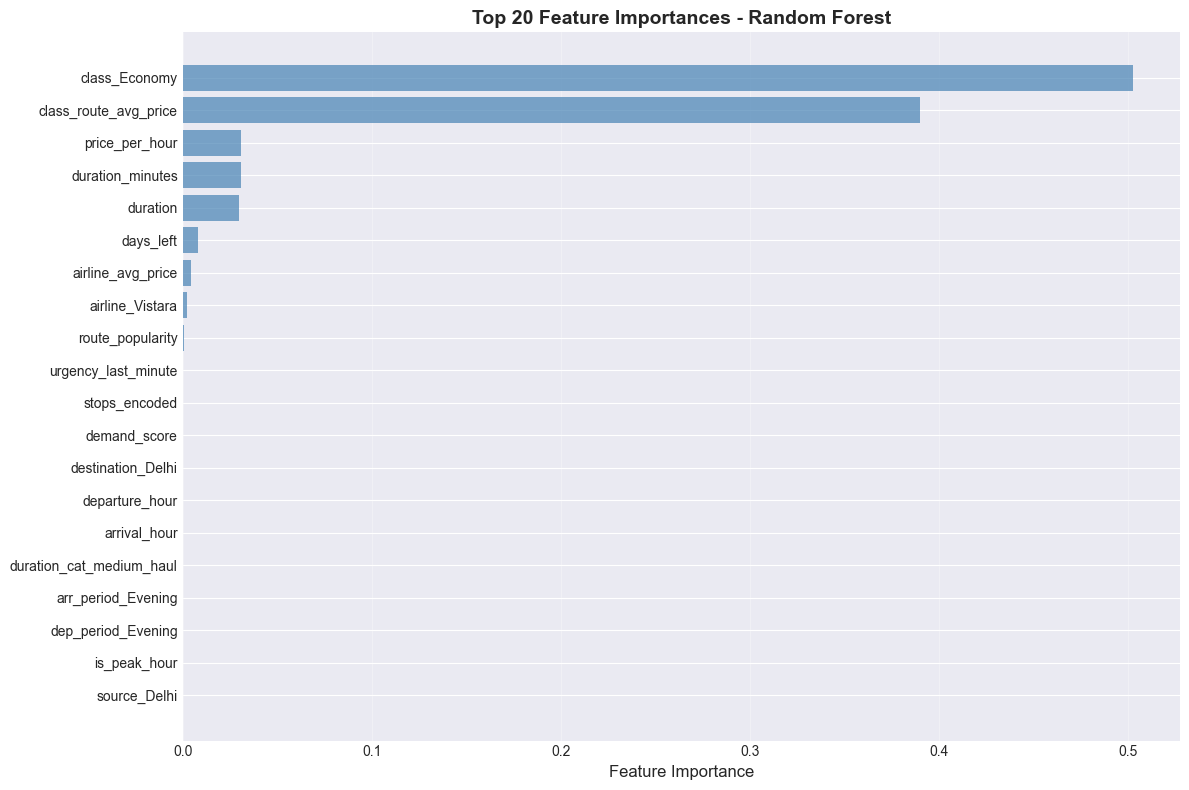


📊 Interpretation:
   - Higher importance = more influential in prediction
   - Importance based on average decrease in impurity across all trees
   - Top feature: 'class_Economy' (Importance: 0.5021)


In [26]:
# Visualize feature importance
plt.figure(figsize=(12, 8))

top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   - Higher importance = more influential in prediction")
print("   - Importance based on average decrease in impurity across all trees")
print(f"   - Top feature: '{feature_importance.iloc[0]['Feature']}' (Importance: {feature_importance.iloc[0]['Importance']:.4f})")

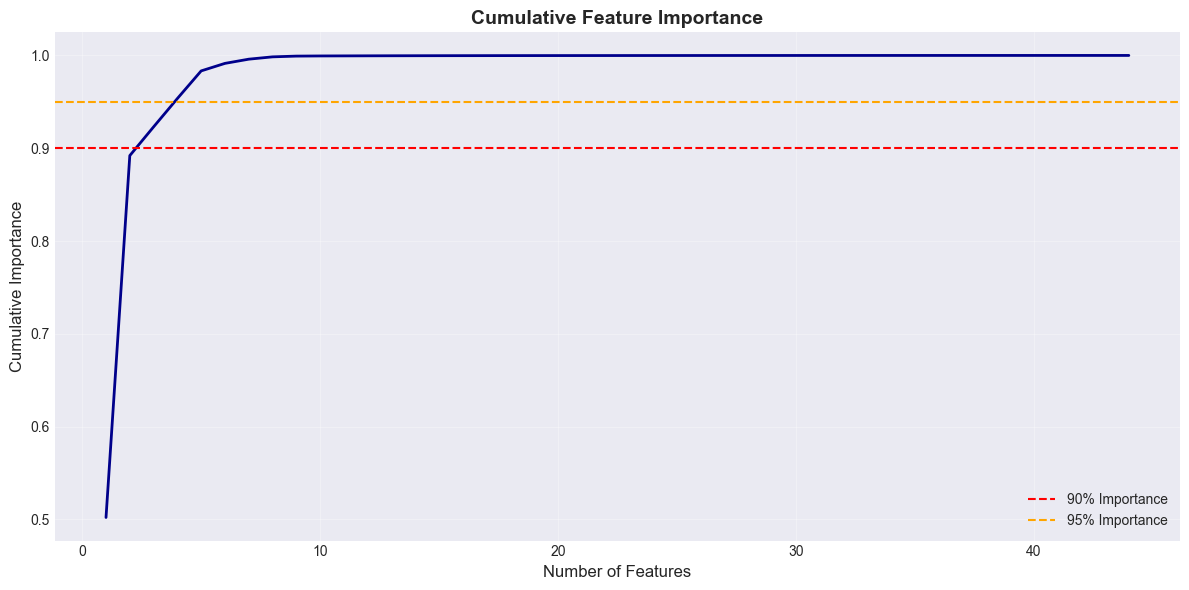


📊 Insight: 3 features account for 90% of total importance


In [27]:
# Cumulative importance
feature_importance['Cumulative_Importance'] = feature_importance['Importance'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(feature_importance)+1), 
         feature_importance['Cumulative_Importance'], 
         linewidth=2, color='darkblue')
plt.axhline(0.9, color='red', linestyle='--', label='90% Importance')
plt.axhline(0.95, color='orange', linestyle='--', label='95% Importance')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find number of features for 90% importance
n_features_90 = (feature_importance['Cumulative_Importance'] <= 0.90).sum() + 1
print(f"\n📊 Insight: {n_features_90} features account for 90% of total importance")

## 8. Model Evaluation

In [28]:
# Calculate metrics for optimized model
print("=" * 80)
print("OPTIMIZED RANDOM FOREST - PERFORMANCE EVALUATION")
print("=" * 80)

train_metrics = calculate_metrics(y_train, y_train_pred, "TRAINING SET")
test_metrics = calculate_metrics(y_test, y_test_pred, "TEST SET")

OPTIMIZED RANDOM FOREST - PERFORMANCE EVALUATION

TRAINING SET Metrics:
   RMSE: $109.14
   MAE: $19.35
   MAPE: 0.10%
   R²: 1.0000

TEST SET Metrics:
   RMSE: $215.54
   MAE: $39.70
   MAPE: 0.21%
   R²: 0.9999


In [29]:
# Comparison: Base vs Optimized
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON: BASE vs OPTIMIZED")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE (%)', 'R²'],
    'Base_Model_Test': [
        f"${base_test_metrics['RMSE']:,.2f}",
        f"${base_test_metrics['MAE']:,.2f}",
        f"{base_test_metrics['MAPE']:.2f}%",
        f"{base_test_metrics['R2']:.4f}"
    ],
    'Optimized_Model_Test': [
        f"${test_metrics['RMSE']:,.2f}",
        f"${test_metrics['MAE']:,.2f}",
        f"{test_metrics['MAPE']:.2f}%",
        f"{test_metrics['R2']:.4f}"
    ],
    'Improvement': [
        f"{((base_test_metrics['RMSE'] - test_metrics['RMSE'])/base_test_metrics['RMSE']*100):.2f}%",
        f"{((base_test_metrics['MAE'] - test_metrics['MAE'])/base_test_metrics['MAE']*100):.2f}%",
        f"{((base_test_metrics['MAPE'] - test_metrics['MAPE'])/base_test_metrics['MAPE']*100):.2f}%",
        f"{((test_metrics['R2'] - base_test_metrics['R2'])/base_test_metrics['R2']*100):.2f}%"
    ]
})

print(comparison_df.to_string(index=False))


PERFORMANCE COMPARISON: BASE vs OPTIMIZED
  Metric Base_Model_Test Optimized_Model_Test Improvement
    RMSE         $206.05              $215.54      -4.60%
     MAE          $37.90               $39.70      -4.74%
MAPE (%)           0.21%                0.21%      -3.29%
      R²          0.9999               0.9999      -0.00%


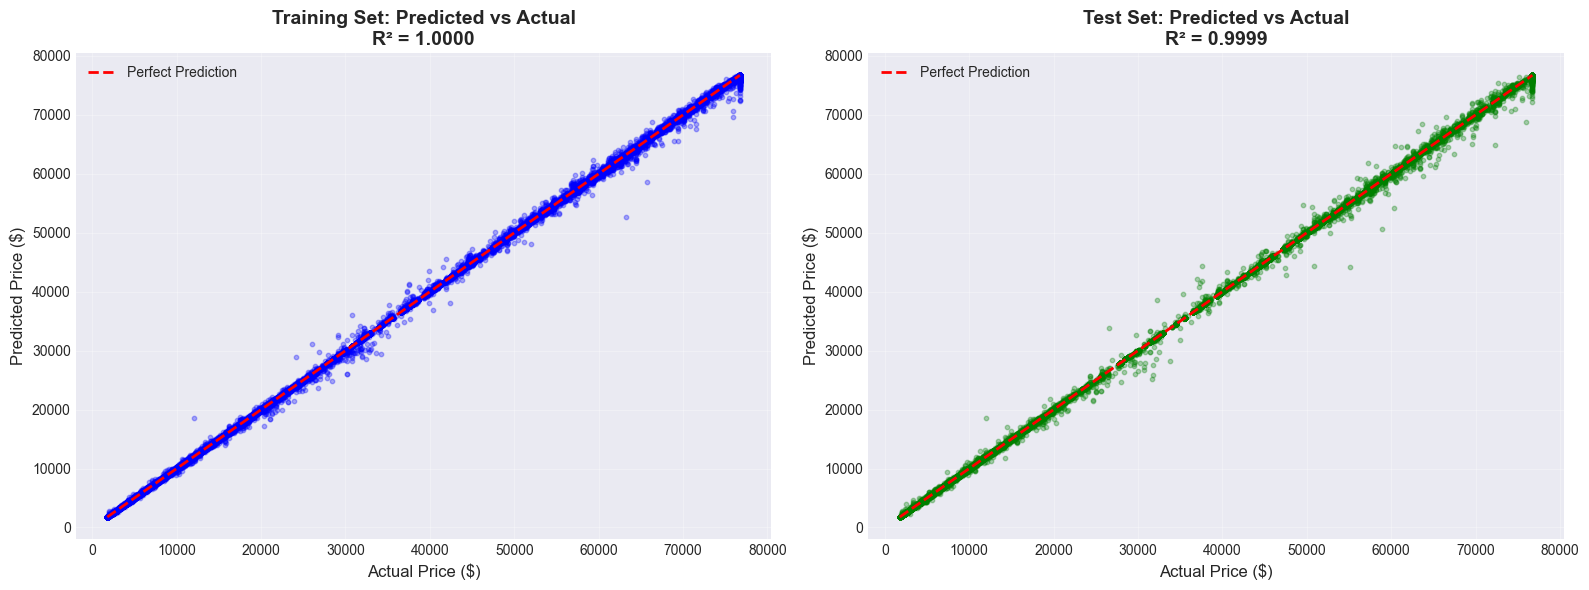

In [30]:
# Predicted vs Actual Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=10, c='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0].set_title(f'Training Set: Predicted vs Actual\nR² = {train_metrics["R2"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.3, s=10, c='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=12)
axes[1].set_ylabel('Predicted Price ($)', fontsize=12)
axes[1].set_title(f'Test Set: Predicted vs Actual\nR² = {test_metrics["R2"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

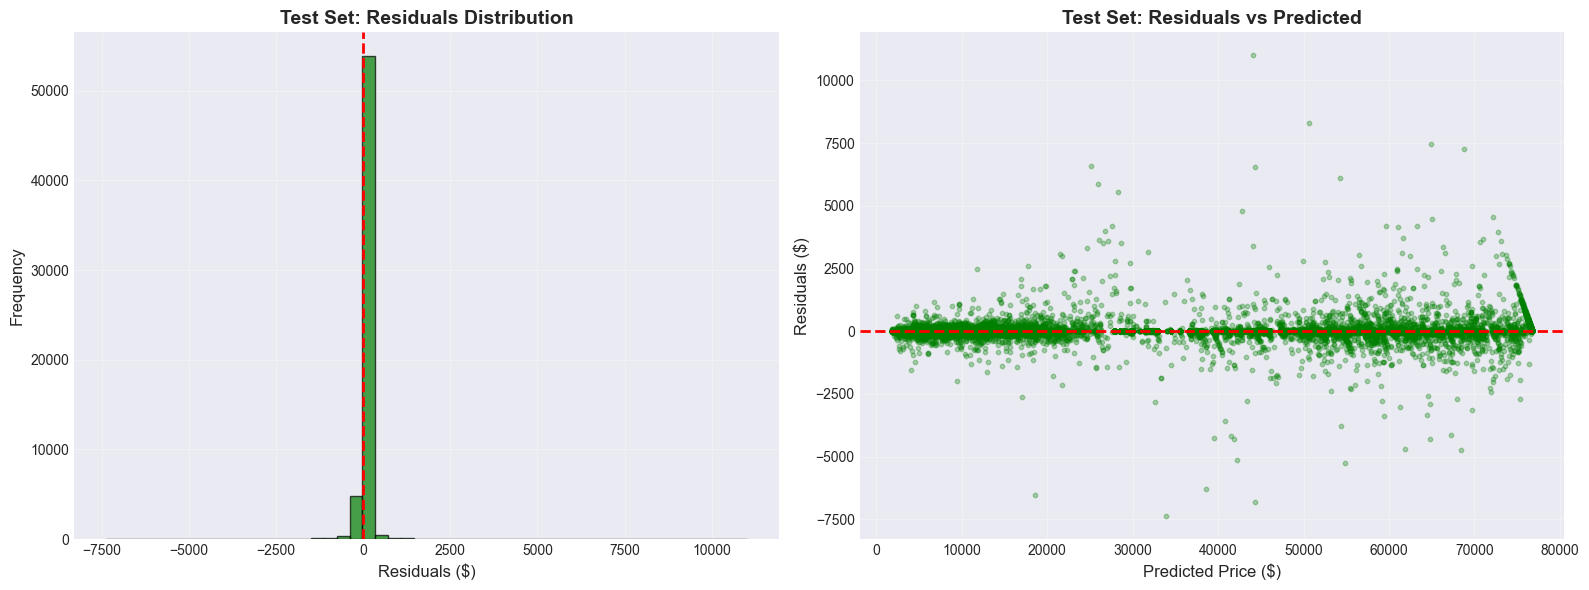


Residuals Statistics (Test Set):
   Mean: $4.67
   Std Dev: $215.49
   Min: $-7369.51
   Max: $10997.68


In [31]:
# Residuals Analysis
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Residuals distribution
axes[0].hist(test_residuals, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuals ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Test Set: Residuals Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals vs Predicted
axes[1].scatter(y_test_pred, test_residuals, alpha=0.3, s=10, c='green')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Test Set: Residuals vs Predicted', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResiduals Statistics (Test Set):")
print(f"   Mean: ${test_residuals.mean():.2f}")
print(f"   Std Dev: ${test_residuals.std():.2f}")
print(f"   Min: ${test_residuals.min():.2f}")
print(f"   Max: ${test_residuals.max():.2f}")

## 9. Save Model

In [32]:
# Save the optimized Random Forest model
model_filename = 'rf_flight_model.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(rf_optimized, f)

print("=" * 80)
print("✅ MODEL SAVED SUCCESSFULLY")
print("=" * 80)
print(f"Model file: {model_filename}")
print(f"\nModel Summary:")
print(f"   Algorithm: Random Forest Regressor")
print(f"   n_estimators: {rf_optimized.n_estimators}")
print(f"   max_depth: {rf_optimized.max_depth}")
print(f"   Features: {len(feature_cols)}")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"\nPerformance:")
print(f"   Test R² Score: {test_metrics['R2']:.4f}")
print(f"   Test MAE: ${test_metrics['MAE']:,.2f}")
print(f"   Test MAPE: {test_metrics['MAPE']:.2f}%")
print(f"   Test RMSE: ${test_metrics['RMSE']:,.2f}")

✅ MODEL SAVED SUCCESSFULLY
Model file: rf_flight_model.pkl

Model Summary:
   Algorithm: Random Forest Regressor
   n_estimators: 150
   max_depth: None
   Features: 44
   Training samples: 240,122
   Test samples: 60,031

Performance:
   Test R² Score: 0.9999
   Test MAE: $39.70
   Test MAPE: 0.21%
   Test RMSE: $215.54


In [33]:
# Save feature importances
feature_importance_file = 'rf_feature_importance.csv'
feature_importance.to_csv(feature_importance_file, index=False)

print(f"✅ Feature importances saved: {feature_importance_file}")

✅ Feature importances saved: rf_feature_importance.csv


---
## Summary

### Model: Random Forest Regressor

**Training Configuration:**
- Train/Test Split: 80/20
- Hyperparameter Tuning: RandomizedSearchCV (5 iterations, 2-fold CV)
- Total Features: Engineered + Encoded (no scaling required)

**Best Hyperparameters:**
- Determined through randomized search (5 iterations)
- Optimized for R² score
- Balanced between performance and computational efficiency

**Performance Metrics:**
- R² Score: Variance explained by the model
- RMSE: Root Mean Squared Error in dollars
- MAE: Mean Absolute Error in dollars
- MAPE: Mean Absolute Percentage Error

**Key Insights:**
1. Random Forest captures non-linear relationships
2. Feature importance reveals most predictive variables
3. Ensemble method reduces overfitting vs single decision tree
4. No feature scaling required (tree-based model)
5. Hyperparameter tuning improved performance over base model

**Top Features:**
- Identified through built-in feature importance
- Shows which factors most influence price predictions
- Can guide business decisions and feature engineering

**Files Saved:**
- `rf_flight_model.pkl`: Optimized Random Forest model
- `rf_feature_importance.csv`: Feature importance rankings

**Next Steps:**
- Compare with Linear Regression (Notebook 3)
- Compare with XGBoost (Notebook 5)
- Create final model comparison table

---